# Work-flow

Example with the 'sample data set'

__Example with PAN image, single channel!__


## Step 0
Importing the libraries and the functions

In [334]:
from __future__ import print_function

import json
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.ion()
from shapely.geometry import Point, Polygon
import shapely.wkt

import geopandas as gpd
from rasterio.plot import show
import sys
import geojson
from descartes import PolygonPatch


from skimage.transform import resize
import skimage.draw
from skimage.io import imsave, imread


from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
plt.rcParams['figure.figsize'] = (8, 8)

# Prettier plotting with seaborn
import seaborn as sns; 
sns.set(font_scale=1.5)
sns.set_style("white")

## Step 1
Path directory images and mask

In [351]:

def path_from_AOI_id(AOI_id):

    if AOI_id=='AOI_5':
        Path_AOI_id='AOI_5_Khartoum_Train'
    if AOI_id=='AOI_4':
        Path_AOI_id='AOI_4_Shanghai_Train'
    if AOI_id=='AOI_3':
        Path_AOI_id='AOI_3_Paris_Train'
    if AOI_id=='AOI_2':
        Path_AOI_id='AOI_2_Vegas_Train'
   
    return Path_AOI_id

def name_file(image_path):
    #Select the tiff file inside a directory'
    images=[]
    for file in os.listdir(image_path):
        if file.endswith(".tif"):
            images.append(file)
            
    return images

def name_file_geojson(image_path):
    #Select the geojson file inside a directory'
    images=[]
    for file in os.listdir(image_path):
        if file.endswith(".geojson"):
            images.append(file)
            
    return images

def get_ch_rows_columns(image_path):
    # get the number of channela, rows and columns
    # of the images that are inside the im directory (image_path)
    # it doesn't work with the mask()
    # it takes the first image as example
    images=name_file(image_path)
    if len(images)>0:
        name=os.path.join(image_path, images[1])
    
        with rio.open(name, "r") as src2:
            array = src2.read()
        return array.shape
    else:
        print('no image in the directory')

def get_image_id(image_name):
    #for example, image_name=PAN_AOI_5_Khartoum_img9 takes just AOI_5_Khartoum_img9
    # it is used to get the masks inside the summary table
    x=image_name.split('AOI')
    image_id='AOI'+ x[-1]
    image_id=image_id.split('.tif')[0]
    return image_id 


#open the summary of the polygons observed in each city
def summary_poly_AOI_id(AOI_id):
    image_path=get_image_path(AOI_id,'Sum')
    os.listdir(image_path) 
    for file in os.listdir(image_path):
        if file.endswith(".csv"):
            name_file= image_path+file
            df=pd.read_csv(name_file)     
    return df

## image path


#MUL_path    = path_from_AOI_id(AOI_id)+'/MUL/'
#PAN_path    = path_from_AOI_id(AOI_id)+'/PAN/'
#MUL_ps_path = path_from_AOI_id(AOI_id)+'/MUL-PanSharpen/'
#RGB_path    = path_from_AOI_id(AOI_id)+'/RGB-PanSharpen/'
#mask_path   = path_from_AOI_id(AOI_id)+'/geojson/buildings/'


def get_image_path(AOI_id,fmt):
    if fmt=='MUL':
        image_path     = path_from_AOI_id(AOI_id)+'/MUL/'
    if fmt=='PAN':
        image_path     = path_from_AOI_id(AOI_id)+'/PAN/'
    if fmt=='PAN_sh':
        image_path    = path_from_AOI_id(AOI_id)+'/MUL-PanSharpen/'
    if fmt=='RGB':
        image_path     = path_from_AOI_id(AOI_id)+'/RGB-PanSharpen/'
    if fmt=='mask':
        image_path     = path_from_AOI_id(AOI_id)+'/geojson/buildings/'
    if fmt=='Sum':
        image_path     = path_from_AOI_id(AOI_id)+'/summaryData/'
    return image_path


AOI_id='AOI_2'
fmt='PAN'
image_path=get_image_path(AOI_id,fmt)
get_ch_rows_columns(image_path)



(1, 650, 650)

In [336]:
#spacenet_sample/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img5184.tif


## Step 2.1
Saving the images in a np.array --> X_train (n_images, nrows,ncolumn) 

In [337]:
AOI_id='AOI_2'
fmt='PAN'
image_path=get_image_path(AOI_id,fmt)



def create_x_train_data(image_path):
    images = name_file(image_path)
    total = len(images)
    ch,rows,cols=get_ch_rows_columns(image_path)

    imgs = np.ndarray((total, rows, cols), dtype=np.uint8)
    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        # 1. reading the image with imread
        # 2. transforming in a np.array with np.array([])
        # 3. saving the array in the i position of the imgs(Nimages x rows x columns)
        img = imread(os.path.join(image_path, image_name), as_gray=True)
        img = np.array([img])
        imgs[i] = img
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    #np.save('imgs_train.npy', imgs)
    #np.save('imgs_mask_train.npy', imgs_mask)
    #print('Saving to .npy files done.')
    return imgs





## Step 2.2
Saving the corresponding masks in a np.array --> Ytrain (n_images, nrows,rcolumn).
It takes the polygon from the  csv file in the SummaryData

In [352]:
AOI_id='AOI_2'
fmt='Sum'

image_id='AOI_4_Shanghai_img3344'
df=summary_poly_AOI_id(AOI_id)
    
def create_mask_im(df,image_id):
    #for each image_id create a mask based on the polygons
    # described in the summary table
    im_mask = np.zeros((650, 650))

    
    for idx, row in df[df.ImageId == image_id].iterrows():
        shape_obj = shapely.wkt.loads(row.PolygonWKT_Pix)
        if shape_obj.exterior is not None:
            coords = list(shape_obj.exterior.coords)
            x = [round(float(pp[0])) for pp in coords]
            y = [round(float(pp[1])) for pp in coords]
            yy, xx = skimage.draw.polygon(y, x, (650, 650))
            im_mask[yy, xx] = 1

            interiors = shape_obj.interiors
            for interior in interiors:
                coords = list(interior.coords)
                x = [round(float(pp[0])) for pp in coords]
                y = [round(float(pp[1])) for pp in coords]
                yy, xx = skimage.draw.polygon(y, x, (650, 650))
                im_mask[yy, xx] = 0
    im_mask = (im_mask > 0.5).astype(np.uint8)
    return im_mask


def create_y_train_data(image_path,df):
    # takes the image_id of the tiff images and 
    # check if they can be found in df
    
    images = name_file(image_path)
    total = len(images)

    imgs_mask = np.ndarray((total, 650, 650), dtype=np.uint8)
    i = 0
    print('-'*30)
    print('Creating y training images...')
    print('-'*30)
    for image_name in images:
         # 1. control if the image_id in image_name is contained in df
         # 2. store the mask in the imgs.mask (in the same order of the images)  
        image_id= get_image_id(image_name)
        if len(df[df.ImageId == image_id]) == 0:
            print("ImageId not found on summaryData: {}".format(image_id))
        else:
            img = create_mask_im(df,image_id)
            imgs[i] = img
            
        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    #np.save('imgs_train.npy', imgs)
    #np.save('imgs_mask_train.npy', imgs_mask)
    #print('Saving to .npy files done.')
    return imgs

In [353]:
AOI_id='AOI_2'
fmt='PAN'
image_path=get_image_path(AOI_id,fmt)

df=summary_poly_AOI_id(AOI_id)
X=create_x_train_data(image_path)
Y=create_y_train_data(image_path,df)


------------------------------
Creating training images...
------------------------------
Done: 0/10 images
Loading done.
------------------------------
Creating y training images...
------------------------------
Done: 0/10 images
Loading done.


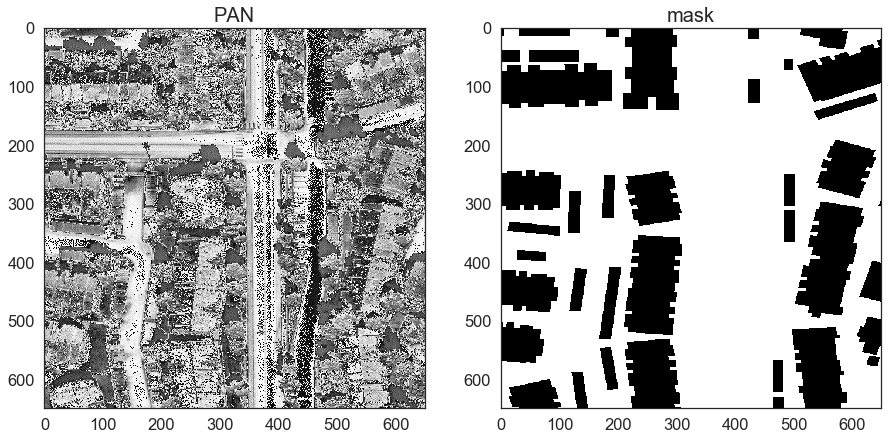

In [354]:
n_i=9
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,15))
ax1.imshow(X[n_i],cmap='Greys') 
ax1.set_title("PAN", 
             fontsize=20);
ax2.imshow(Y[n_i],cmap='Greys')
ax2.set_title("mask", 
             fontsize=20);



The images and the polygons are saved in np.arrays (X and Y).
When plotted they are very noisy in comparison with the original images as it is shown below: 

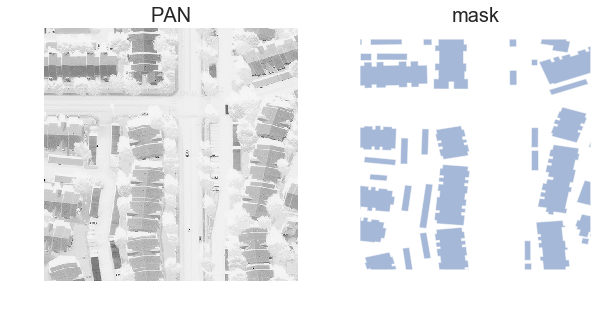

In [345]:


images = name_file(image_path)
address = image_path+images[n_i]


level=1
with rio.open(address, "r") as src2:
    PAN=src2.read(level,masked=True)
    spatial_extent = rio.plot.plotting_extent(src2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,10))

ax1.imshow(PAN, 
           cmap='Greys')

ax1.set_title('PAN', 
             fontsize=20);
ax1.set_axis_off()

## mask
fmt='mask'
image_path2=get_image_path(AOI_id,fmt)
#images2 = name_file_geojson(image_path2)
imm=images[n_i].replace('.tif','').replace('PAN_','')
images2='buildings_'+imm+'.geojson'
#search the same file with.geojson 


address2 = image_path2+images2


json_data = gpd.read_file(address2)

json_data.plot(ax=ax2,
             alpha=0.5)
ax2.set_title("mask", 
             fontsize=20);
ax2.set_axis_off()
#spatial_extent = plotting_extent(lidar_chm)






# Step 3
- Pre processing the images: resizing, filtering, normalizing
- Merging the input data from different image types (MUL+RGB+PAN+PAN_sharp) _(or training the model separately for each type of this file and then averaging the results?_
- Repeating for each type of image type
- Split the data set in a training and a testing part

In [355]:
def preprocess_ris(imgs,img_cols,img_rows):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p




# Step 4
Model definition: example taken from https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [348]:
smooth=1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


# Step 5
Train and predict

# Step 6
Evaluate the result
